In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from collections import Counter

%matplotlib inline

In [2]:
# fn = 'QF608_actual_data.xlsx'
# fn_atmvol = 'QF608_atmvol_data.xlsx'
fn = 'For vol harvesting team.xlsx'
fn_vix = 'VIX.csv'

In [71]:
import warnings
warnings.filterwarnings('ignore')

In [337]:
pd.options.display.max_rows = 1000

### process stock info for backtest use

In [3]:
vix_data = pd.read_csv(fn_vix, parse_dates = [0])
# vix_data.dropna(inplace = True)
# vix_data.rename(columns = {'Dates': 'Date', 'VIX Index': 'VIX'}, inplace = True)
vix_data.set_index('Date', inplace = True)
vix_data = vix_data[['Adj Close']]
vix_data.rename(columns = {'Adj Close': 'VIX'}, inplace = True)

In [4]:
stock_data = pd.read_excel(fn, sheet_name = 'values', header = [6], index_col=[0], 
                           usecols = [i for i in range(14,83)])

In [5]:
stock_data.rename(columns = {'HSI Index.1': 'HSI Index'}, inplace = True)

In [6]:
stock_data.columns = stock_data.columns.to_series().mask(lambda x: x.str.startswith('Unnamed')).ffill()

In [7]:
stock_data = stock_data.T.set_index('Dates', append=1).T

In [8]:
# intersection of dates
dates_set = sorted(list(set(pd.to_datetime(stock_data.index).values) & set(vix_data.index.values)))

In [9]:
stock_data = stock_data.loc[dates_set]
vix_data = vix_data.loc[dates_set]

In [10]:
stock_prices = stock_data.loc[:, stock_data.columns.get_level_values(1)=='Last Trade/Last Price'].copy()
prices = stock_prices.droplevel(1, axis = 1)
prices = prices.astype(float)
prices = abs(prices)
# prices = prices[::-1]

In [11]:
returns = np.log(prices/prices.shift(1))
returns.dropna(inplace = True)

In [12]:
stock_vol = stock_data.loc[:, stock_data.columns.get_level_values(1).str.contains('Moneyness')].copy()
selected = list(set(stock_vol.columns.get_level_values(0)))

In [14]:
delta_skew_df = pd.DataFrame()
for stock in selected:
    temp = stock_vol.loc[:,stock].copy()
    temp.rename(columns = {'3 Month 100% Moneyness Implied Volatility':'100VOL',
                    '3 Month 90% Moneyness Implied Volatility':'90VOL',
                    '3 Month 110% Moneyness Implied Volatility':'110VOL'}, inplace = True)
    temp.dropna(inplace = True)
#     temp = temp[::-1]
    temp['skew_'] = temp['90VOL'] - temp['110VOL']
    temp = temp.skew_ - temp.skew_.shift(1)
    temp.dropna(inplace = True)
    temp.name = stock
    if delta_skew_df.empty:
        delta_skew_df = temp
    else:
        delta_skew_df = pd.concat((delta_skew_df,temp), axis = 1, join = 'inner')

In [16]:
#delta_skew_df.to_csv('delta_skew_df.csv')

In [18]:
dates = delta_skew_df.index

In [19]:
#set prices and returns to the same window as options data
prices = prices.loc[dates]
returns = returns.loc[dates]

In [25]:
def get_shift(ret, deltaskew, stock_a, stock_b, corr_window = corr_window, max_shift = max_shift):
    if stock_a == stock_b:
        return 0
    else:
        pass
    
    ret_corr = ret[[stock_a,stock_b]].rolling(window = corr_window).corr() #calculate correlation between assets' returns
    actual_corr = ret_corr[stock_a][:, stock_b] # obtain only the pairwise correlation from corr matrix
    actual_corr.dropna(inplace = True) 

    test_corr = deltaskew[[stock_a,stock_b]].rolling(window = corr_window).corr() # obtain correlation between assets' delta skew
    implied_corr = test_corr[stock_a][:, stock_b]
    implied_corr.dropna(inplace = True)
    
    # set names of correlation for referencing later
    implied_corr.name = 'implied_corr'
    actual_corr.name = 'actual_corr'
    
    #now to compare actual_corr and implied_corr to find optimal shift window
    graph = []
    for i in range(1, max_shift+1): # iterate through different shifts to get maximum value
        shift_ = i
        icorr_subset = implied_corr.shift(shift_) #apply shift to implied correlation
        test = pd.concat([icorr_subset, actual_corr], join = 'inner', axis = 1) # obtain df of overlapping data
        test.dropna(inplace = True)
        result = test.rolling(window = corr_window).corr()['implied_corr'][:,'actual_corr']
        a = [i, result[result > 0].count()/ result.count(), test.corr().iloc[0, 1]]
#         print(a)
        graph.append(a) # save results to storage 'graph'

    df = pd.DataFrame(graph, columns=['shift','percent_positive_corr', 'overall_corr'])
    df['product'] = df.eval('percent_positive_corr * overall_corr')
    optimal_shift = df[['product']].idxmax()[0]+1
    return optimal_shift

In [21]:
start_date = dates[0]
y1_date = start_date + relativedelta(years = 1)

In [22]:
y1_ret = returns.loc[start_date: y1_date]

In [24]:
y1_delta_skew_df = delta_skew_df.loc[start_date: y1_date]
y1_delta_skew_df

,ED7 Comdty,SX5E Index,RX1 Comdty,AS51 Index,HSCEI Index,G 1 Comdty,LC1 Comdty,S 1 Comdty,YM1 Comdty,SPX Index,NKY Index,CL1 Comdty,GC1 Comdty,HO1 Comdty,HSI Index,C 1 Comdty,TY1 Comdty
2006-01-05,-0.04,0.1338,0.63,2.4779,-1.7648,0.04,-0.06,0.95,0.73,0.1954,1.4141,0.04,-0.23,-7.10543e-15,0.5047,0.68,0.04
2006-01-06,0.33,-0.2702,-1.71,-2.3882,0.6791,-0.09,0.9,-0.44,0.46,-0.3152,2.6237,0.05,-0.03,0.02,0.5473,-0.17,0.15
2006-01-09,0.07,0.0085,0.07,1.0816,0.5325,-0.06,-0.7,-0.21,3.45,0.1685,0,-0.01,-1.15,0.01,0.1209,0.73,0.14
2006-01-10,-4.5,0.3365,-1.17,-3.6372,-0.0981,0.04,-0.23,0.53,-2.15,-0.0211,-2.6376,-0.18,0.93,-0.01,-0.4385,-0.31,-0.06
2006-01-11,4.87,-0.2353,3.97,2.4473,-1.6954,0.01,-0.4,0.52,-1.43,-0.2874,0.4889,0.23,-0.04,0.01,-0.2093,-0.37,-0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-28,-0.28,-0.0057,0.02,0.411,0,-0.07,0.32,0.04,0,-0.6228,0.0876,0.08,0.44,-0.02,0,-0.24,0
2006-12-29,-0.11,0.1244,0.02,0,-3.1949,0.06,-0.23,-0.26,0,0.3595,0.2853,0.05,-0.47,-0.01,19.2826,0.17,-0.15
2007-01-03,0.09,-0.2439,0.08,-0.3299,0.0943,-0.03,-0.24,0.68,0,-0.4367,0,-0.46,0.26,0.32,-0.3132,0.14,0.03
2007-01-04,0.22,0.2501,-0.21,-0.1345,0.4645,-0.03,0.34,0.35,0,-0.0757,-0.3842,0.91,0.27,0.06,0.3573,-0.45,0.19


In [28]:
# 'selected' is list of selected assets (not invested in)
# pairings = {}
# for i in range(len(selected)):
#     for j in range(len(selected)):
#         if i != j:
#             stock_a, stock_b = selected[i], selected[j]
#             pairings[(stock_a, stock_b)] = get_shift(y1_ret, y1_delta_skew_df, stock_a, stock_b) 

<ipython-input-25-ed8f57073afb>:27: RuntimeWarning: invalid value encountered in long_scalars
  a = [i, result[result > 0].count()/ result.count(), test.corr().iloc[0, 1]]


In [33]:
# pairings

{('ED7 Comdty', 'SX5E Index'): 73,
 ('ED7 Comdty', 'RX1 Comdty'): 1,
 ('ED7 Comdty', 'AS51 Index'): 2,
 ('ED7 Comdty', 'HSCEI Index'): 35,
 ('ED7 Comdty', 'G 1 Comdty'): 65,
 ('ED7 Comdty', 'LC1 Comdty'): 73,
 ('ED7 Comdty', 'S 1 Comdty'): 52,
 ('ED7 Comdty', 'YM1 Comdty'): 73,
 ('ED7 Comdty', 'SPX Index'): 71,
 ('ED7 Comdty', 'NKY Index'): 71,
 ('ED7 Comdty', 'CL1 Comdty'): 61,
 ('ED7 Comdty', 'GC1 Comdty'): 1,
 ('ED7 Comdty', 'HO1 Comdty'): 73,
 ('ED7 Comdty', 'HSI Index'): 12,
 ('ED7 Comdty', 'C 1 Comdty'): 1,
 ('ED7 Comdty', 'TY1 Comdty'): 73,
 ('SX5E Index', 'ED7 Comdty'): 73,
 ('SX5E Index', 'RX1 Comdty'): 55,
 ('SX5E Index', 'AS51 Index'): 70,
 ('SX5E Index', 'HSCEI Index'): 70,
 ('SX5E Index', 'G 1 Comdty'): 54,
 ('SX5E Index', 'LC1 Comdty'): 1,
 ('SX5E Index', 'S 1 Comdty'): 1,
 ('SX5E Index', 'YM1 Comdty'): 3,
 ('SX5E Index', 'SPX Index'): 68,
 ('SX5E Index', 'NKY Index'): 73,
 ('SX5E Index', 'CL1 Comdty'): 45,
 ('SX5E Index', 'GC1 Comdty'): 1,
 ('SX5E Index', 'HO1 Comdty'): 

In [17]:
#set params
corr_window = 90
max_shift = corr_window
corr_quantile = 0.3
vol_quantile = 0.3
min_window = 7 # for readjusting portfolio
vol_harvest_window = 3
VIX_target = 25

## Asset Selection (from vol and corr)

In [34]:
def get_stock_pairs_corr(ret, corr_quantile = corr_quantile):
    corr_matrix = ret.corr()
    q = np.quantile(corr_matrix.values, corr_quantile) #obtain quantile on the lower end
    filtered = corr_matrix[corr_matrix < q]
    stock_list = list(filtered[filtered.notnull()].stack().index)
#     mid = len(stock_list)/2 #only need top half of correlation matrix to obtain pairs
#     stocks_pair = stock_list[:int(mid)] 
#     stocks = [j for pair in stocks_pair for j in pair]
    return stock_list #,stocks

def get_stocks_vol(ret, vol_quantile = vol_quantile):
    vol = ret.std()
    q = np.quantile(vol, vol_quantile)
    return list(vol[vol>q].index)

def filter_pairs(pairs_list, stock_list):
    pairs = []
    n = len(stock_list)
    for i in range(n):
        for j in range(n):
            if j > i:
                a = stock_list[i]
                b = stock_list[j]
                if (a,b) in pairs_list:
                    pairs.append((a,b))
    
    return pairs

In [35]:
stocks_pair = get_stock_pairs_corr(y1_ret)
stocks = get_stocks_vol(y1_ret)

In [36]:
pairs = filter_pairs(stocks_pair, stocks)

In [38]:
for pair in pairs:
    print('{}: {}'.format(pair, pairings[pair]))

('NKY Index', 'HO1 Comdty'): 25
('NKY Index', 'S 1 Comdty'): 1
('HSCEI Index', 'HO1 Comdty'): 9
('HSCEI Index', 'S 1 Comdty'): 73
('HO1 Comdty', 'S 1 Comdty'): 6


In [39]:
y2_date = start_date + relativedelta(years = 2)
y5_date = start_date + relativedelta(years = 5)
prices_ = prices.loc[y2_date: y5_date].copy()
ret_ = returns.loc[y2_date: y5_date].copy()
deltaskew_ = delta_skew_df.loc[y2_date: y5_date].copy()

rolling_corr_ = pd.DataFrame()
n = len(selected)
for i in range(n):
    for j in range(n):
        if i < j:    
            stock_a = selected[i]
            stock_b = selected[j]
            test_corr = deltaskew_[[stock_a,stock_b]].rolling(window = corr_window).corr() # obtain correlation between assets' delta skew
            implied_corr = test_corr[stock_a][:, stock_b]
            implied_corr.dropna(inplace = True)
            implied_corr.name = (stock_a, stock_b)
            
            if rolling_corr_.empty:
                rolling_corr_ = implied_corr
            else:
                rolling_corr_ = pd.concat((rolling_corr_, implied_corr), join = 'inner', axis = 1)
            


In [234]:
# extract atm vol and prices of the same timestamps as rolling corr
ewm_prices = pd.DataFrame(prices_.sum(axis = 1), columns = ['avg_price'])
ewm_prices = ewm_prices.ewm(alpha = 0.2).mean()
ewm_prices['shifted_diff'] = ewm_prices.avg_price - ewm_prices.avg_price.shift(1)

prices_subset_ = prices_.loc[rolling_corr_.index].copy()
vix_ = vix_data.loc[rolling_corr_.index].copy()
ewm_prices_ = ewm_prices.loc[rolling_corr_.index].copy()

vix_['shifted_diff'] = vix_ - vix_.shift(1)
vix_['shift'] = vix_.VIX.shift(1)
vix_['ewm_shifted_diff'] = ewm_prices_.shifted_diff.values

conditions = [
    (vix_['VIX'] > VIX_target) & (vix_['ewm_shifted_diff'] < 0),# & (vix_['shifted_diff'] > 0) & (vix_['shift'] < VIX_target),
    (vix_['VIX'] < VIX_target) & (vix_['shifted_diff'] < 0) & (vix_['shift'] > VIX_target)
]

choices = [4,3]

vix_['rebalance_vix'] = np.select(conditions, choices, default=0)

pairings_shifts = pairings

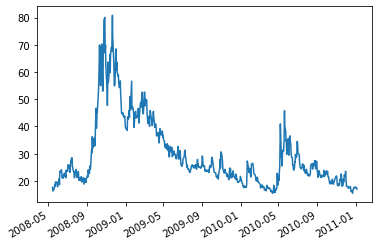

In [208]:
vix_.VIX.plot()

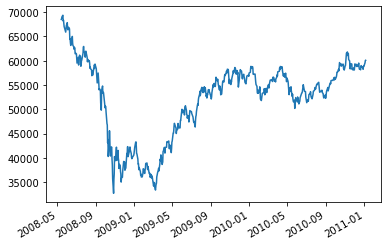

In [238]:
prices_subset_.sum(axis = 1).plot()

In [45]:
prices_subset_['selection'] = np.nan
prices_subset_['selection_pairs'] = np.nan
prices_subset_['rebalance_vc'] = 0
prices_subset_['rebalance_vh'] = 0

len_ = len(prices_subset_)
for i in range(len_): # use index of correlation to loop through
    
    # obtain best correlation pairs
    corr_row = rolling_corr_.iloc[i,:]
    corr_q = np.quantile(corr_row.values, corr_quantile)
    corr_pairs = list(corr_row[corr_row < corr_q].index)

    # obtain best volatile stocks
#     vol_row = atm_vol_df.iloc[i,:]
#     vol_q = np.quantile(vol_row.values, vol_quantile)
#     vol_stocks = vol_row[vol_row > vol_q].index
    
    # obtain count of best stocks to invest in
#     best_selection_pairs = filter_pairs(corr_pairs, vol_stocks)
    best_selection_pairs = corr_pairs # using only correlation as signal
    best_invest = [j for pair in best_selection_pairs for j in pair]
    best_stocks_counter = dict(Counter(best_invest))

    prices_subset_.selection.iloc[i] = [best_stocks_counter] # store best selection in this timestamp
    prices_subset_.selection_pairs.iloc[i] = [best_selection_pairs] # store best pairs
    
    #obtain previous selection and compare
    if i == 0:
        continue # if starting point, just skip to next loop
        
    previous_selection = prices_subset_.selection.iloc[i-1][0]
    previous_pairings = prices_subset_.selection_pairs.iloc[i-1][0]
    
    if best_stocks_counter == previous_selection: 
        #add zero to current counter, which may have a value from previous timestamps
        prices_subset_.rebalance_vc.iloc[i] += 0 
    else:
        # find which assets are to be bought in and sold out
        # then obtain average of the two shifts to decide next rebalance
        
        buy_shifts = []
        sell_shifts = []
        for pair in best_selection_pairs:
            if pair not in previous_pairings: 
                # pairings that signal indicates to buy in
                buy_shifts.append(pairings_shifts[pair]) # obtain shifts from dictionary
        for pair in previous_pairings:
            if pair not in best_selection_pairs: 
                # pairings that signal indicates to sell out
                sell_shifts.append(pairings_shifts[pair])
        
        # set a lower limit to rebalancing (can be same as our normal rebalancing freq)
        shift = max(int(np.mean(buy_shifts + sell_shifts)),min_window) # obtain average of shifts

        if i+shift < len_:
            # if previous and after min_window day already rebalancing, don't add to rebalancing
            if (prices_subset_.rebalance_vc.iloc[i+shift-min_window: i+shift] == 0).all(): 
                a = i+shift+1
                b = i+shift+1+min_window
                if a < len_ and b < len_:
                    if (prices_subset_.rebalance_vc.iloc[i+shift+1: i+shift+1+min_window] == 0).all():
                        prices_subset_.rebalance_vc.iloc[i+shift] += 1 
        
    # vol harvest rebalance
    if i+vol_harvest_window < len_:
        if (prices_subset_.rebalance_vc.iloc[i: i+vol_harvest_window] == 0).all(): 
            # if no vol/corr trigger within vol harvest window,check if have prior vol harvest rebalances
            if (prices_subset_.rebalance_vh.iloc[i: i+vol_harvest_window] == 0).all():
                # if no prior vol harvest rebalances, apply vol harvest rebalance
                prices_subset_.rebalance_vh.iloc[i+vol_harvest_window] += 1

prices_subset_['rebalance_vc'] = prices_subset_['rebalance_vc'].apply(lambda x: 2 if x > 0 else 0)
prices_subset_['rebalance_vh'] = prices_subset_['rebalance_vh'].apply(lambda x: 1 if x > 0 else 0)

/Users/YY/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
prices_subset_ = pd.concat((prices_subset_, vix_.rebalance_vix), axis = 1)

In [47]:
prices_subset_['rebalance_signal'] = prices_subset_[['rebalance_vc', 'rebalance_vh', 'rebalance_vix']].apply(np.max, axis = 1)

In [49]:
# prices_subset_.to_pickle('sample_output')

## Apply value multiplier

In [50]:
stock_info_fn = 'stock_info.csv'
data_fn = 'sample_output'

prices_subset_ = pd.read_pickle(data_fn)
info = pd.read_csv(stock_info_fn, index_col=[0])

In [51]:
info.FUT_VAL_PT = info.FUT_VAL_PT.astype(float)
date_ = prices_subset_.index
value = {key:value for (key, value) in zip(info.index.values, info.FUT_VAL_PT.values)}

# apply multiplication
for col in prices_subset_.columns:
    if col in selected:
        value_multiplier = value[col]
        prices_subset_[col] = prices_subset_[col] * value_multiplier

In [58]:
# prices_subset_.to_pickle('vol_harvest_input')

In [355]:
start_date

Timestamp('2006-01-05 00:00:00')

# Testing parameters

In [400]:
index_list = prices.columns.to_list()
len_asset = len(index_list)
pairs = [(index_list[i], index_list[j]) for i in range(len_asset) for j in range(len_asset) if i < j]
pairs

[('SPX Index', 'SX5E Index'),
 ('SPX Index', 'NKY Index'),
 ('SPX Index', 'HSI Index'),
 ('SPX Index', 'AS51 Index'),
 ('SPX Index', 'HSCEI Index'),
 ('SPX Index', 'TY1 Comdty'),
 ('SPX Index', 'ED7 Comdty'),
 ('SPX Index', 'RX1 Comdty'),
 ('SPX Index', 'G 1 Comdty'),
 ('SPX Index', 'YM1 Comdty'),
 ('SPX Index', 'CL1 Comdty'),
 ('SPX Index', 'HO1 Comdty'),
 ('SPX Index', 'GC1 Comdty'),
 ('SPX Index', 'LC1 Comdty'),
 ('SPX Index', 'C 1 Comdty'),
 ('SPX Index', 'S 1 Comdty'),
 ('SX5E Index', 'NKY Index'),
 ('SX5E Index', 'HSI Index'),
 ('SX5E Index', 'AS51 Index'),
 ('SX5E Index', 'HSCEI Index'),
 ('SX5E Index', 'TY1 Comdty'),
 ('SX5E Index', 'ED7 Comdty'),
 ('SX5E Index', 'RX1 Comdty'),
 ('SX5E Index', 'G 1 Comdty'),
 ('SX5E Index', 'YM1 Comdty'),
 ('SX5E Index', 'CL1 Comdty'),
 ('SX5E Index', 'HO1 Comdty'),
 ('SX5E Index', 'GC1 Comdty'),
 ('SX5E Index', 'LC1 Comdty'),
 ('SX5E Index', 'C 1 Comdty'),
 ('SX5E Index', 'S 1 Comdty'),
 ('NKY Index', 'HSI Index'),
 ('NKY Index', 'AS51 Index')

In [481]:
start_date_ = datetime.datetime(2006, 1, 5)

In [482]:
t1 = start_date_ + relativedelta(years = 5)
t2 = start_date_ + relativedelta(years = 11)

In [483]:
delta_skew_df.loc[t1:t2]

,ED7 Comdty,SX5E Index,RX1 Comdty,AS51 Index,HSCEI Index,G 1 Comdty,LC1 Comdty,S 1 Comdty,YM1 Comdty,SPX Index,NKY Index,CL1 Comdty,GC1 Comdty,HO1 Comdty,HSI Index,C 1 Comdty,TY1 Comdty
2011-01-05,-4.42,0.019,0.18,-0.344,-0.0139,0.06,0.35,-0.25,-1.72,-0.1864,0.0911,0.01,0.04,0.07,-0.822,0.08,-0.78
2011-01-06,-17.84,-0.3423,0.01,0.7705,-0.6323,-0.01,-0.13,0.34,1.9,-0.0512,-0.592,0.05,3.55271e-15,-0.14,0.8335,-0.23,0.17
2011-01-07,-0.62,0.7903,0.37,-0.0311,0.9232,-0.04,0.07,0.23,0.41,0.3687,-0.2962,0.01,0.05,-0.05,-0.441,-0.08,-0.08
2011-01-10,15.35,-0.5711,-0.18,-0.2877,0.7482,-0.02,-0.13,-0.47,0.14,-0.2725,0,0.04,0.06,0.21,0.401,-0.18,-0.11
2011-01-11,-8.67,0.0586,-0.06,-0.9386,-1.0838,0.03,0.13,0.33,-0.04,0.3179,0.2766,-0.03,-1.29,-0.14,-0.435,0.24,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-29,1.71,0.0688,8.88178e-16,0.8635,0.3447,0.03,-0.15,-0.13,-2.93,0.2351,1.1439,2.74,-0.33,0.01,-0.1725,-0.2,0.21
2016-12-30,0.38,0.0739,-0.02,-0.4704,-0.2832,0,0.12,-0.03,-7.55,0.3342,0.9633,0.86,0,0.66,-0.0426,0.02,-0.29
2017-01-03,-4.39,-0.4993,-0.37,0.3601,-0.2259,0,0,0.22,5.87,-0.5872,0,-0.81,-0.41,0.26,-0.075,-0.19,0.37
2017-01-04,-1.22,-0.2329,0,-0.165,-0.3794,-0.03,0.33,-0.31,-1.43,-0.7077,-1.2531,-0.39,-0.39,-0.99,-0.5648,0.08,-0.31


In [484]:
delta_skew_df.index[0]

Timestamp('2006-01-05 00:00:00')

In [515]:
a = 1
b = 4
if a != 1 or b != 3:
    print('a = 2')
else:
    print('yes')

a = 2


In [646]:
def f(y1_ret, prices, returns, delta_skew_df,
    initial_capital = 10000000,
    transaction_cost_percent = 0.0005,
    risky_portfolio_weight = 0.8,
    corr_window = 90,
    min_shift_window = 5,
    max_shift = 90,
    corr_quantile = 0.3,
    vol_quantile = 0.3,
    min_window = 7, # for readjusting portfolio
    vol_harvest_window = 3,
    VIX_target = 50,
    input_data = None,
    start_date = delta_skew_df.index[0],
    start_year = 2, end_year = 5,
#     # specify outputs:
    bh_only = False,
    vh_only = False,
    corr_only = False):
    
    stocks_pair = get_stock_pairs_corr(y1_ret)
    stocks = get_stocks_vol(y1_ret)
    pairs = filter_pairs(stocks_pair, stocks)
    y2_date = start_date + relativedelta(years = start_year)
    y5_date = start_date + relativedelta(years = end_year) 
    
    prices_ = prices.loc[y2_date: y5_date].copy()
    ret_ = returns.loc[y2_date: y5_date].copy()
    deltaskew_ = delta_skew_df.loc[y2_date: y5_date].copy()
    
    index_list = prices.columns.to_list()
    len_asset = len(index_list)
    pairs = [(index_list[i], index_list[j]) for i in range(len_asset) for j in range(len_asset) if i < j]
    
    rolling_corr_ = pd.DataFrame()
    for i in range(len_asset):
        for j in range(len_asset):
            if i < j:    
                stock_a = index_list[i]
                stock_b = index_list[j]
                test_corr = deltaskew_[[stock_a,stock_b]].rolling(window = corr_window).corr() # obtain correlation between assets' delta skew
                implied_corr = test_corr[stock_a][:, stock_b]
                implied_corr.dropna(inplace = True)
                implied_corr.name = (stock_a, stock_b)

                if rolling_corr_.empty:
                    rolling_corr_ = implied_corr
                else:
                    rolling_corr_ = pd.concat((rolling_corr_, implied_corr), join = 'inner', axis = 1)
    
    # extract atm vol and prices of the same timestamps as rolling corr
    ewm_prices = pd.DataFrame(prices_.sum(axis = 1), columns = ['avg_price'])
    ewm_prices = ewm_prices.ewm(alpha = 0.2).mean()
    ewm_prices['shifted_diff'] = ewm_prices.avg_price - ewm_prices.avg_price.shift(1)
    
    prices_subset_ = prices_.loc[rolling_corr_.index].copy()
    vix_ = vix_data.loc[rolling_corr_.index].copy()
    ewm_prices_ = ewm_prices.loc[rolling_corr_.index].copy()

    vix_['shifted_diff'] = vix_ - vix_.shift(1)
    vix_['shift'] = vix_.VIX.shift(1)
    vix_['ewm_shifted_diff'] = ewm_prices_.shifted_diff.values

    conditions = [
        ((vix_['VIX'] > VIX_target) & (vix_['ewm_shifted_diff'] < 0) & (vix_['shifted_diff'] > 0) & (vix_['shift'] < VIX_target)),
        ((vix_['VIX'] < VIX_target) & (vix_['shifted_diff'] < 0) & (vix_['shift'] > VIX_target))]

    choices = [4,3]

    vix_['rebalance_vix'] = np.select(conditions, choices, default=0)

    pairings_shifts = pairings

    prices_subset_['selection'] = np.nan
    prices_subset_['selection_pairs'] = np.nan
    prices_subset_['rebalance_vc'] = 0
    prices_subset_['rebalance_vh'] = 0

    len_ = len(prices_subset_)
    for i in range(len_): # use index of correlation to loop through

        # obtain best correlation pairs
        corr_row = rolling_corr_.iloc[i,:]
        corr_q = np.quantile(corr_row.values, corr_quantile)
        corr_pairs = list(corr_row[corr_row < corr_q].index)

        # obtain count of best stocks to invest in
        best_selection_pairs = corr_pairs # using only correlation as signal
        best_invest = [j for pair in best_selection_pairs for j in pair]
        best_stocks_counter = dict(Counter(best_invest))

        prices_subset_.selection.iloc[i] = [best_stocks_counter] # store best selection in this timestamp
        if vh_only:
            prices_subset_.selection_pairs.iloc[i] = [pairs]
        else:
            prices_subset_.selection_pairs.iloc[i] = [best_selection_pairs] # store best pairs

        #obtain previous selection and compare
        if i == 0:
            continue # if starting point, just skip to next loop

        previous_selection = prices_subset_.selection.iloc[i-1][0]
        previous_pairings = prices_subset_.selection_pairs.iloc[i-1][0]

        if best_stocks_counter == previous_selection: 
            #add zero to current counter, which may have a value from previous timestamps
            prices_subset_.rebalance_vc.iloc[i] += 0 
        else:
            # find which assets are to be bought in and sold out
            # then obtain average of the two shifts to decide next rebalance

            buy_shifts = []
            sell_shifts = []
            for pair in best_selection_pairs:
                if pair not in previous_pairings: 
                    # pairings that signal indicates to buy in
                    buy_shifts.append(pairings_shifts[pair]) # obtain shifts from dictionary
            for pair in previous_pairings:
                if pair not in best_selection_pairs: 
                    # pairings that signal indicates to sell out
                    sell_shifts.append(pairings_shifts[pair])

            # set a lower limit to rebalancing (can be same as our normal rebalancing freq)
            shift = max(int(np.min(buy_shifts + sell_shifts)),min_shift_window) # obtain minimum of shifts

            if i+shift < len_:
                # if previous and after min_window day already rebalancing, don't add to rebalancing
                if (prices_subset_.rebalance_vc.iloc[i+shift-min_window: i+shift] == 0).all(): 
                    a = i+shift+1
                    b = i+shift+1+min_window
                    if a < len_ and b < len_:
                        if (prices_subset_.rebalance_vc.iloc[i+shift+1: i+shift+1+min_window] == 0).all():
                            prices_subset_.rebalance_vc.iloc[i+shift] += 1 

        # vol harvest rebalance
        if i+vol_harvest_window < len_:
            if (prices_subset_.rebalance_vc.iloc[i: i+vol_harvest_window] == 0).all(): 
                # if no vol/corr trigger within vol harvest window,check if have prior vol harvest rebalances
                if (prices_subset_.rebalance_vh.iloc[i: i+vol_harvest_window] == 0).all():
                    # if no prior vol harvest rebalances, apply vol harvest rebalance
                    prices_subset_.rebalance_vh.iloc[i+vol_harvest_window] += 1

    prices_subset_['rebalance_vc'] = prices_subset_['rebalance_vc'].apply(lambda x: 2 if x > 0 else 0)
    prices_subset_['rebalance_vh'] = prices_subset_['rebalance_vh'].apply(lambda x: 1 if x > 0 else 0)

    prices_subset_ = pd.concat((prices_subset_, vix_.rebalance_vix), axis = 1)

    if vh_only:
        prices_subset_['rebalance_signal'] = [1 if (i%20 == 0) else 0 for i in range(len(prices_subset_))]

    elif corr_only:
        prices_subset_['rebalance_signal'] = prices_subset_[['rebalance_vc', 'rebalance_vh']].apply(np.max, axis = 1)
    else:
        prices_subset_['rebalance_signal'] = prices_subset_[['rebalance_vc', 'rebalance_vh', 'rebalance_vix']].apply(np.max, axis = 1)
    
    stock_info_fn = 'stock_info.csv'
    fx_fn = 'fx_spot.csv'
    info = pd.read_csv(stock_info_fn, index_col=[0])
    fx = pd.read_csv(fx_fn, index_col = [0], parse_dates = [0])
    
    info.FUT_VAL_PT = info.FUT_VAL_PT.astype(float)
    date_ = prices_subset_.index
    value = {key:value for (key, value) in zip(info.index.values, info.FUT_VAL_PT.values)}

    # apply multiplication
    for col in prices_subset_.columns:
        if col in selected:
            value_multiplier = value[col]
            prices_subset_[col] = prices_subset_[col] * value_multiplier
    
    data = prices_subset_
    date_ = data.index
    fx['USDUSD'] = 1
    
    fx_convert = {key:(crncy+'USD') for (key, crncy) in zip(info.index.values, info.CRNCY.values)}
    
    rolling_vol_window = corr_window # set the same
    
    data_fx = data.loc[:, index_list].copy()
    fx_temp = fx.loc[data_fx.index]
    
    for asset in data_fx.columns:
        data_fx[asset] = data_fx[asset] * fx_temp[fx_convert[asset]]
    
    # calculate rolling std
    rolling_std_data = data_fx.loc[:, index_list].rolling(rolling_vol_window).std().dropna()
    
    # filter data based on rolling std's timeframe
    date_ = rolling_std_data.index
    data = data.loc[date_]
    fx = fx.loc[date_] #filter only fx data for dates that are in dataset
#     data_2 = data.copy()
#     data_2['rebalance_signal'] = [1 if (i%vol_harvest_window == 0) else 0 for i in range(len(data_2))]
    
#     if input_data:
#         data = input_data.loc[date_] #input data has prices, rebalance signal, and selection
    
#########vol harvest

    def vol_harvest(df, index_list, initial_capital, risky_portfolio_weight, fx, fx_convert, rolling_std_data):
        
        data = df.copy() # dont affect original data
        data = data.query('rebalance_signal >= 1') #filter signals
        data['capital'] = 0 #capital at that timestamp
        data['transaction_cost'] = 0
        data['net_profit'] = 0
        data['asset_nominal'] = 0

        for asset in index_list: #create frame to fill in calculations later
            data[asset +'_weight'] = 0
            data[asset +'_capital'] = 0
            data[asset +'_shares'] = 0
            data[asset +'_profit'] = 0
        
        j = 0
        for i in range(len(data)):
            
            signal = data.rebalance_signal.iloc[i] # signal for every timestamp
            
            if signal == 4:
                tracker = 1
                pass
            if j == 0:
                tracker = 0 # track when vix is triggered and waiting to buy in
                current_portfolio = [] # for normal vol harvesting where the current portfolio has to be recorded before
                previous_selection_pairs = []
                previous_asset_prices = {}
                
            # vol for each asset at timestamp
            rolling_std = rolling_std_data.iloc[i]

            if j == 0:
                capital = initial_capital
                
            else: # update capital changes from price movements
######                 for asset in data['asset_nominal'].iloc[i-1][0].keys():
                if tracker == 1 or signal == 3:
                    pass
                else:
                    for asset in current_portfolio.keys():
                        fx_rate = fx[fx_convert[asset]].iloc[i]
                        previous_shares = data[asset + '_shares'].iloc[i-1]
                        previous_price = previous_asset_prices[asset] #data[asset].iloc[i-1]
                        current_price = data[asset].iloc[i] * fx_rate
                        delta_prices = (current_price - previous_price)
                        pnl = delta_prices * previous_shares
                        capital += pnl # update capital from sale of assets --> capital tracks total value of portfolio

            if capital < 0:
                return 0
                break
            
            cash = (1-risky_portfolio_weight) * capital
            risky_allocation = capital - cash
            n_pair = len(data['selection_pairs'].iloc[i][0])
            proportion = 1/n_pair # proportion of portfolio for each pair
            
            # prepare dict of asset: total capital allocated
            asset_nominal = {}
            if (j == 0 or signal != 1 or signal != 4): 
                # if first instance or 
                # if signal is 2 or 3, and not in vix trigger state
                for (stock_a, stock_b) in data['selection_pairs'].iloc[i][0]:
                    assigned_pair_capital = risky_allocation * proportion
                    stock_a_vol = rolling_std[stock_a]
                    stock_b_vol = rolling_std[stock_b]
                    total_pair_vol = stock_a_vol + stock_b_vol
                    assigned_a = (stock_b_vol/total_pair_vol) * assigned_pair_capital
                    assigned_b = (stock_a_vol/total_pair_vol) * assigned_pair_capital

                    if stock_a in asset_nominal.keys():
                        asset_nominal[stock_a] += assigned_a
                    else:
                        asset_nominal[stock_a] = assigned_a

                    if stock_b in asset_nominal.keys():
                        asset_nominal[stock_b] += assigned_b
                    else:
                        asset_nominal[stock_b] = assigned_b
#                     previous_selection_pairs = data['selection_pairs'].iloc[i][0]
            else:
                if signal != 4: # if signal is 1 and vix not triggered
                    n_pair = len(previous_selection_pairs)
                    proportion = 1/n_pair # proportion of portfolio for each pair
                    for (stock_a, stock_b) in previous_selection_pairs:
                        assigned_pair_capital = risky_allocation * proportion
                        stock_a_vol = rolling_std[stock_a]
                        stock_b_vol = rolling_std[stock_b]
                        total_pair_vol = stock_a_vol + stock_b_vol
                        assigned_a = (stock_b_vol/total_pair_vol) * assigned_pair_capital
                        assigned_b = (stock_a_vol/total_pair_vol) * assigned_pair_capital

                        if stock_a in asset_nominal.keys():
                            asset_nominal[stock_a] += assigned_a
                        else:
                            asset_nominal[stock_a] = assigned_a

                        if stock_b in asset_nominal.keys():
                            asset_nominal[stock_b] += assigned_b
                        else:
                            asset_nominal[stock_b] = assigned_b

            # store dict
            data['asset_nominal'].iloc[i] = [asset_nominal]
            
            if j == 0: #first instance
#                 print(asset_nominal)
                bought_value = 0
                for asset, nominal in asset_nominal.items():
                    fx_rate = fx[fx_convert[asset]].iloc[i]
                    weight = nominal/risky_allocation
                    price = data[asset].iloc[i] * fx_rate # USD
                    shares = nominal/price #number of shares allocated to selected asset
                    
                    # store values
                    data[asset +'_weight'].iloc[i] = weight
                    data[asset +'_capital'].iloc[i] = nominal
                    data[asset +'_shares'].iloc[i] = shares
                    
                    previous_asset_prices[asset] = price
                    
                    # need not update asset profit since default value is 0
                    bought_value += nominal

                transaction_cost = bought_value * transaction_cost_percent
                data['transaction_cost'].iloc[i] = transaction_cost
                capital -= transaction_cost
                data['net_profit'].iloc[i] = -transaction_cost # profit will be transaction cost
                data['capital'].iloc[i] = capital
                current_portfolio = data['asset_nominal'].iloc[i][0] # set current portfolio
                previous_selection_pairs = data['selection_pairs'].iloc[i][0] # update selection pairs
            
                j += 1
            
            else:

                # check for signal
                # normal vol harvest = 1
                # correlation trigger = 2
                # buy-in after vix trigger = 3 # should only happen after a prior vix trigger
                # sell-out signal from vix trigger = 4

                if signal == 4: # vix triggered
                    # sell out previous selection
                    sold_value = 0
                    for asset in data['asset_nominal'].iloc[i-1][0].keys():
                        fx_rate = fx[fx_convert[asset]].iloc[i]
                        previous_shares = data[asset + '_shares'].iloc[i-1] 
                        previous_price = previous_asset_prices[asset] #data[asset].iloc[i-1]
                        current_price = data[asset].iloc[i] * fx_rate
                        delta_prices = (current_price - previous_price)
                        pnl = delta_prices * previous_shares

                        #set new shares, weight, capital allocation for asset to 0 (default value) since selling out
                        data[asset +'_profit'].iloc[i] = pnl # price movements of asset still results in pnl (change to capital)
                        sold_value += previous_shares * current_price
                    
                    transaction_cost = sold_value * transaction_cost_percent
                    data['transaction_cost'].iloc[i] = transaction_cost
                    capital -= transaction_cost
                    data['net_profit'].iloc[i] = capital - data.capital.iloc[i-1]
                    data['capital'].iloc[i] = capital # purely cash position

                    tracker = 1 # update tracker
                    current_portfolio = [] # sell out so current portfolio is empty
                    previous_selection_pairs = []
                    previous_asset_prices = {}
                    continue

                if (signal == 3 and tracker == 0) or (signal != 3 and tracker == 1): 
                    # in case the first buy-in occurs without a prior vix trigger
                    # or vix triggered, but no signal to buy-in yet
                    # do nothing

                    # roll forward weight, capital, shares details for next rebalancing/reconstruction of portfolio
                    data[asset +'_weight'].iloc[i] = data[asset +'_weight'].iloc[i-1]
                    data[asset +'_capital'].iloc[i] = data[asset +'_capital'].iloc[i-1]
                    data[asset +'_shares'].iloc[i] = data[asset +'_shares'].iloc[i-1]

                    # need not update transaction costs and net profit as default value is 0
                    data['capital'].iloc[i] = np.nan # datapoints to be dropped later 
                    # cannot update capital as updated value will not be from rebalancing
                    # previous selection pairs also remains
                    # need not update current portfolio
                    continue

                elif signal == 3 and tracker == 1:
                    # execute buy-in 
                    bought_value = 0
                    
                    # buy-in using current portfolio
                    for asset, nominal in data['asset_nominal'].iloc[i][0].items():
                        fx_rate = fx[fx_convert[asset]].iloc[i]
                        price = data[asset].iloc[i] * fx_rate # USD
                        shares = nominal/price # number of shares allocated to selected asset
                        weight = nominal/risky_allocation
                        data[asset +'_weight'].iloc[i] = weight
                        data[asset +'_capital'].iloc[i] = nominal
                        data[asset +'_shares'].iloc[i] = shares
                        
                        previous_asset_prices[asset] = price
                        
                        # need not update asset profit since default value is 0
                        bought_value += shares * price
                        
                    transaction_cost = bought_value * transaction_cost_percent
                    data['transaction_cost'].iloc[i] = transaction_cost
                    capital -= transaction_cost
                    data['net_profit'].iloc[i] = -transaction_cost
                    data['capital'].iloc[i] = capital #update capital from transaction costs

                    tracker = 0 # reset tracker
                    current_portfolio = data['asset_nominal'].iloc[i][0] # update current portfolio
                    previous_selection_pairs = data['selection_pairs'].iloc[i][0] # update previous selection
                    continue

                if (signal != 3 and tracker == 0): # signal 1 and 2 when vix not triggered
                    if signal == 1: # portfolio does not change
                        new_selection = current_portfolio
                    else: # if signal == 2, obtain the new portfolio construction
                        new_selection = data.asset_nominal.iloc[i][0]

                    ### apply new capital values to current timestamp's selection
                    transacted_value = 0 

                    #set of current and previous assets selected
                    selection_set = set((*list(new_selection.keys()), *list(current_portfolio.keys()))) #set of previous and current selection
                    for asset in selection_set: #based on updated capital, calculate new no. of shares etc.

                        # obtain current prices in USD
                        fx_rate = fx[fx_convert[asset]].iloc[i]
                        current_price = data[asset].iloc[i] * fx_rate # USD

                        if signal == 2:
                            if asset in new_selection.keys(): # check if asset is in current selection
                                assigned_capital = asset_nominal[asset] # obtain assigned capital based on updated capital
                            else:
                                assigned_capital = 0

                        else:
                            if asset in asset_nominal.keys(): 
                                # if signal == 1, is in the previous portfolio construction
                                assigned_capital = asset_nominal[asset]
                        
                        current_shares = assigned_capital/current_price # lower shares if prices increased
                        previous_shares = data[asset +'_shares'].iloc[i-1]
                        weight = assigned_capital/risky_allocation
                        #store data
                        if asset in new_selection: # if asset is in latest selection, store data
                            
                            data[asset +'_weight'].iloc[i] = weight 
                            data[asset +'_capital'].iloc[i] = assigned_capital 
                            data[asset +'_shares'].iloc[i] = current_shares
                            
                            previous_asset_prices[asset] = current_price

                        else: # if asset is not in latest selection, set all to 0
                            data[asset +'_weight'].iloc[i] = 0
                            data[asset +'_capital'].iloc[i] = 0
                            data[asset +'_shares'].iloc[i] = 0
                            
                            previous_asset_prices.pop(asset, None)

                        if asset in new_selection and asset in current_portfolio:
                            # if asset is in both previous and current selection, there'll be P&L from price movements
                            previous_price = previous_asset_prices[asset] #data[asset].iloc[i-1] * fx_rate # USD
                            data[asset + '_profit'].iloc[i] = previous_shares * (current_price - previous_price)
                            
                        #update to overall transaction costs for changes 
                        transacted_value += abs(current_shares - previous_shares) * current_price

                    transaction_cost = transacted_value * transaction_cost_percent
                    data['transaction_cost'].iloc[i] = transaction_cost
                    capital -= transaction_cost
                    data['net_profit'].iloc[i] = capital - data.capital.iloc[i-1]
                    data['capital'].iloc[i] = capital 

                    if signal == 2: #if portfolio requires reconstruction, change current portfolio
                        current_portfolio = data['asset_nominal'].iloc[i][0]
                        previous_selection_pairs = data['selection_pairs'].iloc[i][0]
                    # else if signal is 1, dont need to update current portfolio

        data.dropna(inplace = True) # remove timestamps where nothing is done
        return data
#     if vh_only:
#         output = vol_harvest(data_2, index_list, initial_capital, risky_portfolio_weight, fx, fx_convert, rolling_std_data)
#     if not vh_only:
    output = vol_harvest(data, index_list, initial_capital, risky_portfolio_weight, fx, fx_convert, rolling_std_data)
        #     print(output.capital[-1])
#     if input_data:
#         output_2 = vol_harvest(input_data, index_list, initial_capital, risky_portfolio_weight, fx, fx_convert, rolling_std_data)
    def bh(data, index_list, fx, fx_convert, initial_capital, rolling_std_data):

        fx_1 = fx.iloc[0]
        fx_2 = fx.iloc[-1]
        
        starting_prices = data.loc[:,index_list].iloc[0]
        ending_prices = data.loc[:,index_list].iloc[-1]
        
        for asset in starting_prices.index:
            starting_prices[asset] *= fx_1[fx_convert[asset]]
            ending_prices[asset] *= fx_2[fx_convert[asset]]
        
        # vol weighted
        initial_vol = rolling_std_data.iloc[0]
        total_vol = initial_vol.sum()
        numerator = total_vol - initial_vol

        magnitude = (numerator/total_vol).sum()
        weights = numerator/magnitude/total_vol
        amt = weights * initial_capital
        shares = amt/starting_prices
        
        transacted_value = (shares * (starting_prices + ending_prices)).sum()
        transaction_cost = transacted_value * transaction_cost_percent
        return ((((ending_prices - starting_prices) * shares).sum() - transaction_cost)/initial_capital)
    bh_returns = bh(data, index_list, fx, fx_convert, initial_capital, rolling_std_data)
#     print('buy&hold: {}'.format(bh_returns))
#     print('vol_harvesting, rebalancing freq: {}, {}'.format((output.capital[-1]/initial_capital - 1), vol_harvest_window))
    if bh_only:
#         print(bh_returns)
        return bh_returns
    else:
        return (output.capital[-1]/initial_capital - 1)
#         return output


In [ ]:
risk_weights_range = np.arange(0.8, 1.0, 0.1) 
corr_window_range = np.arange(90, 95, 5) # fixed --> probably because options used are of maturity 3M so 90 is best
corr_quantile_range = np.arange(0.2, 0.5, 0.1) # ideal range: (0.3, 0.4)
min_shift_window_range = np.arange(11, 13, 2) # fixed --> minimum forward shift prediction among all assets' signals
min_window_range = np.arange(7, 26, 5) # ideal range: ()
vol_harvest_window_range = np.arange(3 ,15, 2) # ideal range: (7, 11)
VIX_target_range = np.arange(45,51,2) # ideal: (45)

In [647]:
x = pd.DataFrame(columns = ["risk_weight", 'corr_window', 'corr_quantile','min_shift_window',
                        'min_window', 'vh_window', 'vix', 'value'])
for o in VIX_target_range:
    for k in corr_quantile_range:
        for m in min_window_range:
            for j in corr_window_range:
                for n in vol_harvest_window_range:
                    for i in risk_weights_range:
                        for l in min_shift_window_range:
                            value = f(y1_ret, prices, returns, delta_skew_df,
                                    initial_capital = 10000000,
                                    transaction_cost_percent = 0.0005,
                                    risky_portfolio_weight = i,
                                    corr_window = j,
                                    min_shift_window = l,
                                    max_shift = corr_window,
                                    corr_quantile = k,
                                    min_window = m, # for readjusting portfolio
                                    vol_harvest_window = n,
                                    VIX_target = o,
                                     start_year = 2, end_year = 5)
                            x = x.append(pd.Series([i,j,k,l,m,n,o,value], 
                                                   index = ["risk_weight", 'corr_window',
                                                            'corr_quantile', 'min_shift_window',
                                                            'min_window', 'vh_window', 'vix', 'value']),
                                         ignore_index=True)
                            print(i,j,k,l,m,n,o,value)

0.8 90 0.2 11 7 3 45 0.4519799635791901
0.9 90 0.2 11 7 3 45 0.518777529747966
0.8 90 0.2 11 7 5 45 0.4923297634743826
0.9 90 0.2 11 7 5 45 0.5663128095294176
0.8 90 0.2 11 7 7 45 0.47041471899939347
0.9 90 0.2 11 7 7 45 0.5406895785003492
0.8 90 0.2 11 7 9 45 0.4597983118886362
0.9 90 0.2 11 7 9 45 0.5282571661209439
0.8 90 0.2 11 7 11 45 0.4426389105982469
0.9 90 0.2 11 7 11 45 0.5078565582967605
0.8 90 0.2 11 7 13 45 0.43769118448087196
0.9 90 0.2 11 7 13 45 0.5023861156608187
0.8 90 0.2 11 12 3 45 0.45785964472394225


KeyboardInterrupt: 

In [493]:
# using optimised values
output = f(y1_ret, prices, returns, delta_skew_df,
    initial_capital = 10000000,
    transaction_cost_percent = 0.00005,
    risky_portfolio_weight = 0.8,
    corr_window = 90,
    min_shift_window = 11,
    max_shift = corr_window,
    corr_quantile = 0.3,
    vol_quantile = 0.3,
    min_window = 7, # for readjusting portfolio
    vol_harvest_window = 7,
    VIX_target = 45,
    start_year = 5, end_year = 11)

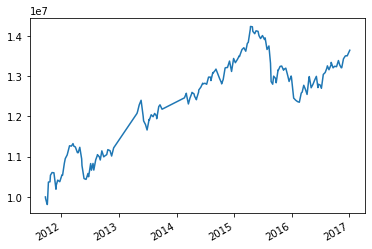

In [345]:
output.capital.plot()

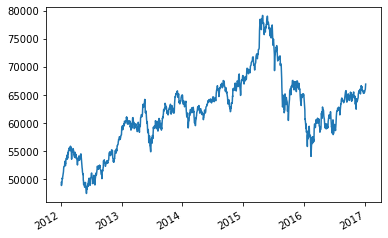

In [576]:
prices.loc['2012-01-05': '2017-01-05'].sum(axis = 1).plot()

In [354]:
# normal vol harvesting
for vh in np.arange(5, 20, 1):
    value_vh = f(y1_ret, prices, returns, delta_skew_df,
    initial_capital = 10000000,
    transaction_cost_percent = 0.00005,
    risky_portfolio_weight = 0.8,
    corr_window = 90,
    min_shift_window = 11,
    max_shift = corr_window,
    corr_quantile = 0.3,
    vol_quantile = 0.3,
    min_window = 7, 
    vol_harvest_window = vh, # insert vol harvest window
    VIX_target = 45,
    normal_vh = True, #set this to true
    start_year = 5, end_year = 7)
#     print(vh, value_vh)

buy&hold: 0.075112239404677
vol_harvesting, rebalancing freq: 0.07153930621064242, 5
buy&hold: 0.075112239404677
vol_harvesting, rebalancing freq: 0.07026843466297605, 6
buy&hold: 0.075112239404677
vol_harvesting, rebalancing freq: 0.07496721949004681, 7
buy&hold: 0.075112239404677
vol_harvesting, rebalancing freq: 0.0706917117815502, 8
buy&hold: 0.075112239404677
vol_harvesting, rebalancing freq: 0.0804764137360654, 9
buy&hold: 0.075112239404677
vol_harvesting, rebalancing freq: 0.0841815670108017, 10
buy&hold: 0.075112239404677
vol_harvesting, rebalancing freq: 0.07922714345587467, 11
buy&hold: 0.075112239404677
vol_harvesting, rebalancing freq: 0.08676485745199591, 12
buy&hold: 0.075112239404677
vol_harvesting, rebalancing freq: 0.06791677434263654, 13
buy&hold: 0.075112239404677
vol_harvesting, rebalancing freq: 0.0647238497156788, 14
buy&hold: 0.075112239404677
vol_harvesting, rebalancing freq: 0.0773477424313549, 15
buy&hold: 0.075112239404677
vol_harvesting, rebalancing freq: 0.

In [580]:
t1 = 5
t2 = 15
bh_output = f(y1_ret, prices, returns, delta_skew_df,
                initial_capital = 10000000,
                transaction_cost_percent = 0.00005,
                risky_portfolio_weight = 0.9,
                corr_window = 90,
                min_shift_window = 11,
                max_shift = corr_window,
                corr_quantile = 0.3,
                vol_quantile = 0.3,
                min_window = 7, # for readjusting portfolio
                vol_harvest_window = 12,
                VIX_target = 45,
                bh_only = True,
                start_year = t1, end_year = t2)

normal_vh_output = f(y1_ret, prices, returns, delta_skew_df,
                    initial_capital = 10000000,
                    transaction_cost_percent = 0.00005,
                    risky_portfolio_weight = 0.9,
                    corr_window = 90,
                    min_shift_window = 11,
                    max_shift = corr_window,
                    corr_quantile = 0.3,
                    vol_quantile = 0.3,
                    min_window = 7, # for readjusting portfolio
                    vol_harvest_window = 12,
                    VIX_target = 45,
                    vh_only=True,
                    start_year = t1, end_year = t2)

corr_output = f(y1_ret, prices, returns, delta_skew_df,
                    initial_capital = 10000000,
                    transaction_cost_percent = 0.00005,
                    risky_portfolio_weight = 0.9,
                    corr_window = 90,
                    min_shift_window = 11,
                    max_shift = corr_window,
                    corr_quantile = 0.3,
                    vol_quantile = 0.3,
                    min_window = 7, # for readjusting portfolio
                    vol_harvest_window = 12,
                    VIX_target = 45,
                    corr_only=True,
                    start_year = t1, end_year = t2)

corr_vix_output = f(y1_ret, prices, returns, delta_skew_df,
                    initial_capital = 10000000,
                    transaction_cost_percent = 0.00005,
                    risky_portfolio_weight = 0.9,
                    corr_window = 90,
                    min_shift_window = 11,
                    max_shift = corr_window,
                    corr_quantile = 0.3,
                    vol_quantile = 0.3,
                    min_window = 7, # for readjusting portfolio
                    vol_harvest_window = 12,
                    VIX_target = 45,
                    start_year = t1, end_year = t2)
# print(bh_output, normal_vh_output, corr_output, corr_vix_output)

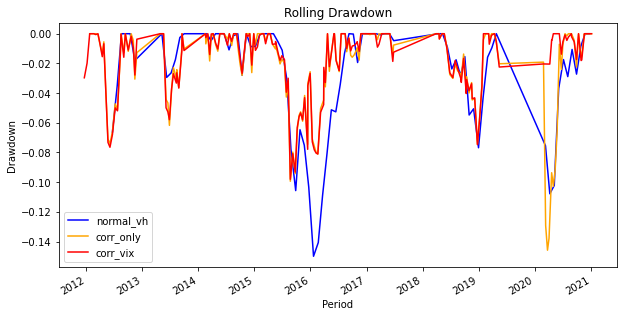

In [632]:
period = 10

fig, ax = plt.subplots(figsize = (10,5))

vh_roll_max = normal_vh_output.capital.rolling(period).max()
normal_vh_drawdown = normal_vh_output.capital/vh_roll_max - 1
normal_vh_drawdown.plot(c = 'blue', ax = ax)

corr_roll_max = corr_output.capital.rolling(period).max()
corr_vh_drawdown = corr_output.capital/corr_roll_max - 1
corr_vh_drawdown.plot(c = 'orange', ax = ax)

corr_vix_roll_max = corr_vix_output.capital.rolling(period).max()
corr_vix_drawdown = corr_vix_output.capital/corr_vix_roll_max - 1
corr_vix_drawdown.plot(c = 'red', ax = ax)
plt.ylabel('Drawdown')
plt.xlabel('Period')
plt.title('Rolling Drawdown')
ax.legend(['normal_vh', 'corr_only', 'corr_vix'])
plt.show()

In [405]:
def compare(start_year, end_year):
    bh_output = f(y1_ret, prices, returns, delta_skew_df,
                    initial_capital = 10000000,
                    transaction_cost_percent = 0.00005,
                    risky_portfolio_weight = 0.8,
                    corr_window = 90,
                    min_shift_window = 11,
                    max_shift = corr_window,
                    corr_quantile = 0.3,
                    vol_quantile = 0.3,
                    min_window = 7, # for readjusting portfolio
                    vol_harvest_window = 12,
                    VIX_target = 45,
                    bh_only = True,
                    start_year = start_year, end_year = end_year)

    normal_vh_output = f(y1_ret, prices, returns, delta_skew_df,
                        initial_capital = 10000000,
                        transaction_cost_percent = 0.00005,
                        risky_portfolio_weight = 0.8,
                        corr_window = 90,
                        min_shift_window = 11,
                        max_shift = corr_window,
                        corr_quantile = 0.3,
                        vol_quantile = 0.3,
                        min_window = 7, # for readjusting portfolio
                        vol_harvest_window = 12,
                        VIX_target = 45,
                        vh_only=True,
                        start_year = start_year, end_year = end_year)

    corr_output = f(y1_ret, prices, returns, delta_skew_df,
                        initial_capital = 10000000,
                        transaction_cost_percent = 0.00005,
                        risky_portfolio_weight = 0.8,
                        corr_window = 90,
                        min_shift_window = 11,
                        max_shift = corr_window,
                        corr_quantile = 0.3,
                        vol_quantile = 0.3,
                        min_window = 7, # for readjusting portfolio
                        vol_harvest_window = 12,
                        VIX_target = 45,
                        corr_only=True,
                        start_year = start_year, end_year = end_year)

    corr_vix_output = f(y1_ret, prices, returns, delta_skew_df,
                        initial_capital = 10000000,
                        transaction_cost_percent = 0.00005,
                        risky_portfolio_weight = 0.8,
                        corr_window = 90,
                        min_shift_window = 11,
                        max_shift = corr_window,
                        corr_quantile = 0.3,
                        vol_quantile = 0.3,
                        min_window = 7, # for readjusting portfolio
                        vol_harvest_window = 12,
                        VIX_target = 45,
                        start_year = start_year, end_year = end_year)
    return (bh_output, normal_vh_output, corr_output, corr_vix_output)

In [511]:
start_year_ = np.arange(2, 14, 2)

In [526]:
comparison = pd.DataFrame(columns = ['B&H', 'Vol_harvest', 'Corr_Vol_harvest', 'Corr_VIX_Vol_harvest'])
for start_year in start_year_:
    end_year = start_year + 2
    results = compare(start_year, end_year)
    print(results)
    comparison = comparison.append(pd.Series(results, index = ['B&H', 'Vol_harvest', 'Corr_Vol_harvest', 'Corr_VIX_Vol_harvest']),
                                  ignore_index = True)
    

(0.29101948298183516, 0.256306112899253, 0.14837548037358883, 0.31025939200745345)
(0.07028539105861638, -0.0017078292822944041, 0.03847143317413071, 0.06325165500677099)
(0.01627987498956476, 0.0998063524884858, 0.10754565881715661, 0.10754565881715661)
(-0.129556758157281, -0.030097463731884044, -0.008820195658655883, -0.008820195658655883)
(0.0964340833893825, 0.05361989963573799, 0.048573653003018746, 0.048573653003018746)
(-0.02109891141465932, 0.010733629208158568, -0.0075210378767642805, -0.0075210378767642805)


In [561]:
comparison

,B&H,Vol_harvest,Corr_Vol_harvest,Corr_VIX_Vol_harvest
0,0.291019,0.256306,0.148375,0.310259
1,0.070285,-0.001708,0.038471,0.063252
2,0.016280,0.099806,0.107546,0.107546
3,-0.129557,-0.030097,-0.008820,-0.008820
4,0.096434,0.053620,0.048574,0.048574
5,-0.021099,0.010734,-0.007521,-0.007521


In [312]:
# x.to_csv('sample_2.csv')

In [562]:
return_ = pd.DataFrame(pd.Series([0] * len(comparison.columns),
                       index = ['B&H', 'Vol_harvest', 'Corr_Vol_harvest', 'Corr_VIX_Vol_harvest']))
return_ = return_.T.append(comparison, ignore_index = True)
growth = return_ + 1

In [570]:
end_period = start_year_ + 2007 + 2
end_period = np.array((2009, *end_period))

In [571]:
growth.index = end_period

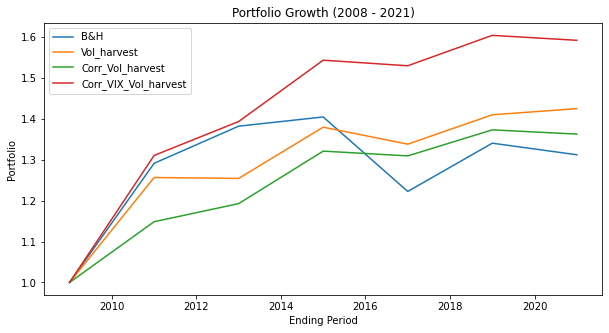

In [572]:
plt.figure(figsize = (10,5))
plt.plot(growth.cumprod())
plt.title('Portfolio Growth (2008 - 2021)')
plt.ylabel('Portfolio')
plt.xlabel('Ending Period')
plt.legend(growth.columns)
plt.show()

In [640]:
# annualized sharpe ratio
(return_.iloc[1:].mean()/2)/(return_.iloc[1:].std()/np.sqrt(2))

B&H                     0.270827
Vol_harvest             0.439220
Corr_Vol_harvest        0.612090
Corr_VIX_Vol_harvest    0.509756
dtype: float64